<a href="https://colab.research.google.com/github/Hitomiblood/ProjectsDataScienceMaster/blob/main/KerasCPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final Aprendizaje Profundo
### Nicolas Leonardo Maldonado - AX840282
### Miguel Santiago Gómez Suárez - AX751708
#### Uso de TPU's GPU's y CPU's en Keras

## Creación de Modelo de clasificación de Imagenes usando Keras y entrenando con CPU:

In [1]:
# Importamos las librerias que vamos a usar
from pathlib import Path

In [2]:
# Cargamos las librerías
import re
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
print("Tensorflow version " + tf.__version__)



Tensorflow version 2.15.0


In [3]:
%%capture
# Obtenemos el DataSet del Link, lo pasamos al Zip y lo descomprimimos
!wget https://www.dropbox.com/s/cv5dfjagvj8fqk8/blindness.zip?dl=1 -O BlindnessDataset.Zip
!unzip BlindnessDataset.Zip

In [4]:
path = Path('blindness/')

In [5]:
trainPath = path/'train'
testPath = path/'test'

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE =  64
IMAGE_SIZE = [512, 512]
Names = ["NO_DR", "MILD","MODERATE","SEVERE","PROLIFERATIVE_DR"]
CLASS_NAMES = ["0", "1","2","3","4"]

In [7]:
# Definir la transformación de datos
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,  # Normalizar los valores de píxeles
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15  # Especificar el porcentaje de datos para validación
)

In [8]:
# Configurar el generador de datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    trainPath,
    target_size=(512, 512),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Usamos 'categorical' para múltiples clases
    subset='training',
    color_mode='rgb',
    classes=CLASS_NAMES  # Especificamos los nombres de las clases
)

# Configurar el generador de datos de validación
validation_generator = train_datagen.flow_from_directory(
    trainPath,
    target_size=(512, 512),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb',
    classes=CLASS_NAMES
)

Found 2339 images belonging to 5 classes.
Found 410 images belonging to 5 classes.


In [9]:
# Definir la transformación de datos para el conjunto de prueba
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255  # Normalizar los valores de píxeles
)

# Configurar el generador de datos de prueba
test_generator = test_datagen.flow_from_directory(
    testPath,
    target_size=(512, 512),  # Tamaño al que se redimensionarán las imágenes
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Usamos 'categorical' para múltiples clases
    color_mode='rgb',  # Especificar el modo de color RGB
    classes=CLASS_NAMES  # Especificamos los nombres de las clases
)

Found 913 images belonging to 5 classes.


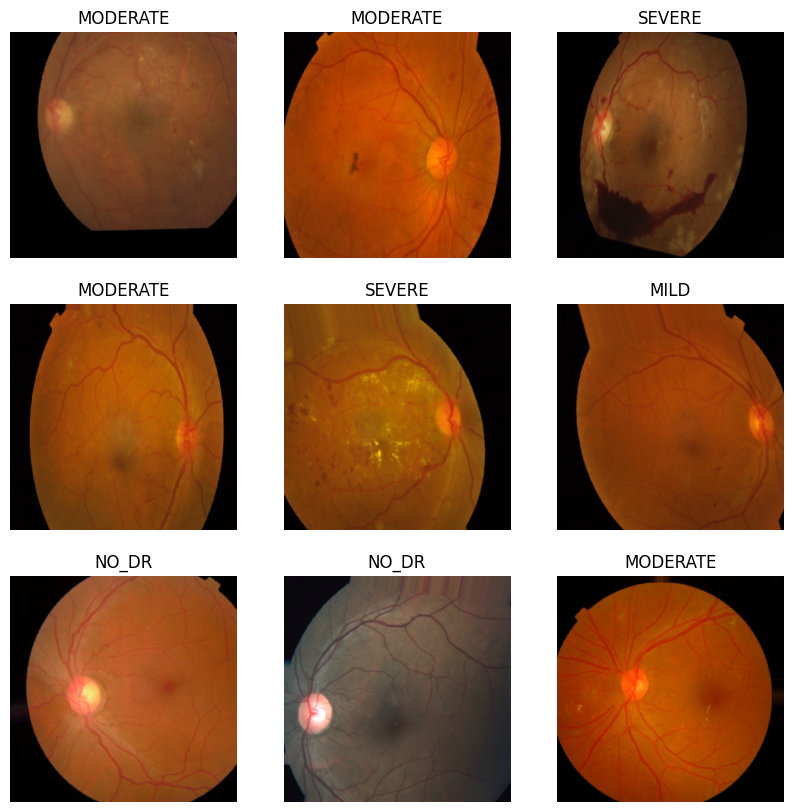

In [10]:
import numpy as np

# Obtener un lote de imágenes y etiquetas de entrenamiento
images, labels = next(train_generator)

# Mostrar algunas imágenes y etiquetas
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])  # Convertir etiquetas codificadas a etiquetas de clase
    plt.title(Names[label_index])  # Usar el nombre de la clase
    plt.axis("off")
plt.show()


In [11]:
def create_blindness_model():
    # Cargar un modelo preentrenado (Xception en este caso) sin la capa de clasificación
    pretrained_model = tf.keras.applications.Xception(
        input_shape=[512, 512, 3],  # Ajustar al tamaño de tus imágenes
        include_top=False,           # No incluir la capa densa final del modelo
        weights='imagenet'          # Utilizar los pesos preentrenados en ImageNet
    )

    # Congelar las capas del modelo preentrenado
    pretrained_model.trainable = False

    # Construir el modelo final
    model = tf.keras.Sequential([
        pretrained_model,                           # Capas preentrenadas
        tf.keras.layers.GlobalAveragePooling2D(),  # Capa de pooling global
        tf.keras.layers.Dense(5, activation='softmax')  # Capa densa de salida con activación softmax
    ])

    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


blindness_model = create_blindness_model()

# Imprimir un resumen del modelo
blindness_model.summary()


83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20871725 (79.62 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [12]:
import time
import keras

# Especifica el número de épocas
EPOCHS = 12

start_time = time.time()

# Entrena el modelo
history = blindness_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[
        keras.callbacks.ModelCheckpoint("blindness_model_keras.keras", save_best_only=True),
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución:", execution_time, "segundos")

Epoch 1/12
37/37 [==============================] - 3337s 90s/step - loss: 1.1773 - accuracy: 0.5985 - val_loss: 1.0124 - val_accuracy: 0.6439
Epoch 2/12
37/37 [==============================] - 3302s 89s/step - loss: 0.9445 - accuracy: 0.6879 - val_loss: 0.8874 - val_accuracy: 0.7073
Epoch 3/12
37/37 [==============================] - 3289s 89s/step - loss: 0.8431 - accuracy: 0.7088 - val_loss: 0.8185 - val_accuracy: 0.7171
Epoch 4/12
37/37 [==============================] - 3270s 89s/step - loss: 0.7881 - accuracy: 0.7242 - val_loss: 0.7780 - val_accuracy: 0.7171
Epoch 5/12
37/37 [==============================] - 3309s 90s/step - loss: 0.7498 - accuracy: 0.7260 - val_loss: 0.7445 - val_accuracy: 0.7439
Epoch 6/12
37/37 [==============================] - 3261s 88s/step - loss: 0.7259 - accuracy: 0.7413 - val_loss: 0.7272 - val_accuracy: 0.7463
Epoch 7/12
37/37 [==============================] - 3290s 90s/step - loss: 0.6998 - accuracy: 0.7495 - val_loss: 0.7002 - val_accuracy: 0.7585

In [13]:
# Evaluación final del modelo en el conjunto de prueba (si lo tienes)
test_loss, test_accuracy = blindness_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 1025s 68s/step - loss: 0.6780 - accuracy: 0.7393
Test Loss: 0.6779682040214539
Test Accuracy: 0.7393209338188171


In [14]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
from huggingface_hub import push_to_hub_keras

# 1. Guardar el modelo Keras en un archivo
blindness_model.save("blindness_model_keras.keras")
push_to_hub_keras(
    blindness_model,
    "Hitomiblood/blindness_modelKerasCPU"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

keras_metadata.pb:   0%|          | 0.00/489k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/83.6M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Hitomiblood/blindness_modelKerasCPU/commit/3f9a9449c52d565dc8ab5ba3c74b14367e8116c7', commit_message='Push Keras model using huggingface_hub.', commit_description='', oid='3f9a9449c52d565dc8ab5ba3c74b14367e8116c7', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
%%capture
# Obtenemos el DataSet del Link, lo pasamos al Zip y lo descomprimimos
!wget https://www.dropbox.com/s/cv5dfjagvj8fqk8/blindness.zip?dl=1 -O BlindnessDataset.Zip
!unzip BlindnessDataset.Zip

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# 3. Utilizar el modelo en un entorno de Hugging Face
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("Hitomiblood/blindness_modelKerasCPU")  # ID del modelo en Hugging Face Hub

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
# Ahora puedes utilizar el modelo como quieras, por ejemplo:
# Definir una función para hacer predicciones
def predict_function(img):
    # Procesar la imagen según sea necesario
    # Por ejemplo, si necesitas redimensionarla a 512x512 y normalizarla, puedes hacerlo aquí

    # Hacer la predicción con el modelo
    prediction = model.predict(np.expand_dims(image_array, axis=0))
    return prediction

In [ ]:
from PIL import Image
import numpy as np

# Cargar la imagen
image_path = "/content/blindness/test/0/002c21358ce6.png"
image = Image.open(image_path)

# Redimensionar la imagen si es necesario
# Por ejemplo, si tu modelo espera imágenes de 512x512, puedes redimensionarla así:
image = image.resize((512, 512))

# Convertir la imagen a un array numpy y normalizar los valores de píxeles
image_array = np.array(image) / 255  # Normalización

# Hacer la predicción utilizando la función predict_function
prediction = predict_function(image_array)

1/1 [==============================] - 4s 4s/step


In [ ]:
prediction

array([[9.9569196e-01, 1.5791574e-03, 1.5773632e-03, 3.7737007e-04,
        7.7426585e-04]], dtype=float32)